# Pipeline: Lane finding on images
We show an end to end processing pipeline from raw uncalibrated images to lanes including lane curvature etc

## Distortion correction
Read in raw uncalibrated images and correct for camera lens distortions

In [1]:
import cv2
import pickle, pprint

# Camera matrix and distortion coefficients obtained in 'Camera Calibration' notebook
calib_file = open('camera_calib.pickle','rb')
calib_dict = pickle.load(calib_file)
print('Read camera calibration objects:')
pprint.pprint(calib_dict)
calib_file.close()

#cameraMatrix = [[1.15777942e+03, 0.00000000e+00, 6.67111049e+02],
# [0.00000000e+00, 1.15282305e+03, 3.86129069e+02],
# [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]
#distCoeffs = [[-0.24688833, -0.02372814, -0.00109843, 0.00035105, -0.00259138]]

def cal_undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist)
    return undist


Read camera calibration objects:
{'cameraMatrix': array([[1.15777942e+03, 0.00000000e+00, 6.67111049e+02],
       [0.00000000e+00, 1.15282305e+03, 3.86129069e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'distCoeffs': array([[-0.24688833, -0.02372814, -0.00109843,  0.00035105, -0.00259138]])}


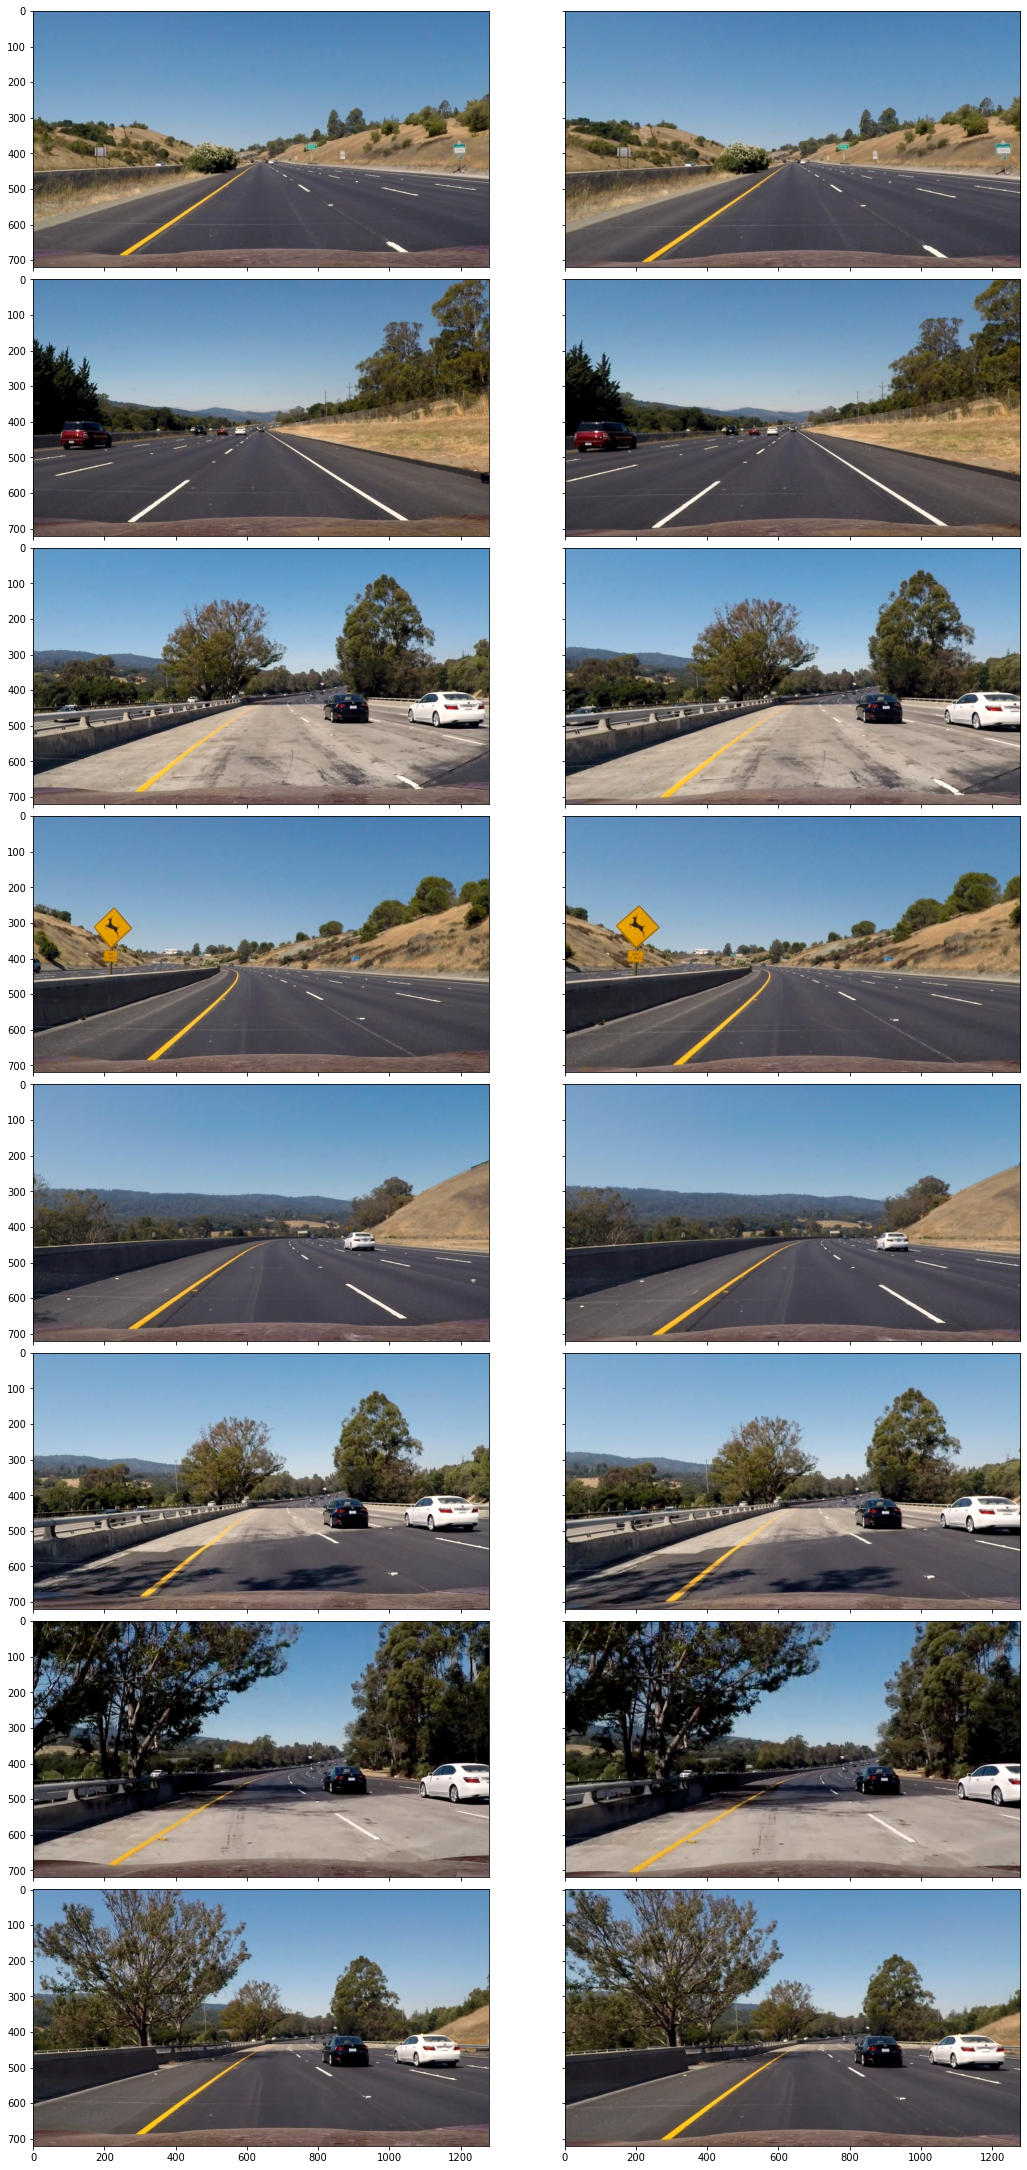

In [2]:
# Apply on test images
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

# Get all file names
path = 'test_images'
file_names = [join(path,f) for f in listdir(path) if (isfile(join(path, f)) and (".jpg" in f))]

# Create canvas to thow original and undistorted images
fig, axes = plt.subplots(nrows=len(file_names), ncols=2,sharex=True,sharey=True,figsize=(15,30))
plt.tight_layout(pad=0.2)

for i, file_name in enumerate(file_names):
    
    # Read image
    img = cv2.imread(file_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Undistort
    undistorted = cal_undistort(img, calib_dict['cameraMatrix'], calib_dict['distCoeffs'])

    # Show
    axes[i][0].imshow(img)
    axes[i][1].imshow(undistorted)
    
    # Save
    save_name = file_name.replace('test_images','output_images').replace('.jpg','_cal.jpg')
    cv2.imwrite(save_name, undistorted)


## Lane Pixels
We use a combination of various gradients, color transforms, et cetera to identify pixels which belong to lane markings

In [3]:
import numpy as np
import cv2

# Function to select pixels belonging to lanes
def lane_pixels(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary,combined_binary
    

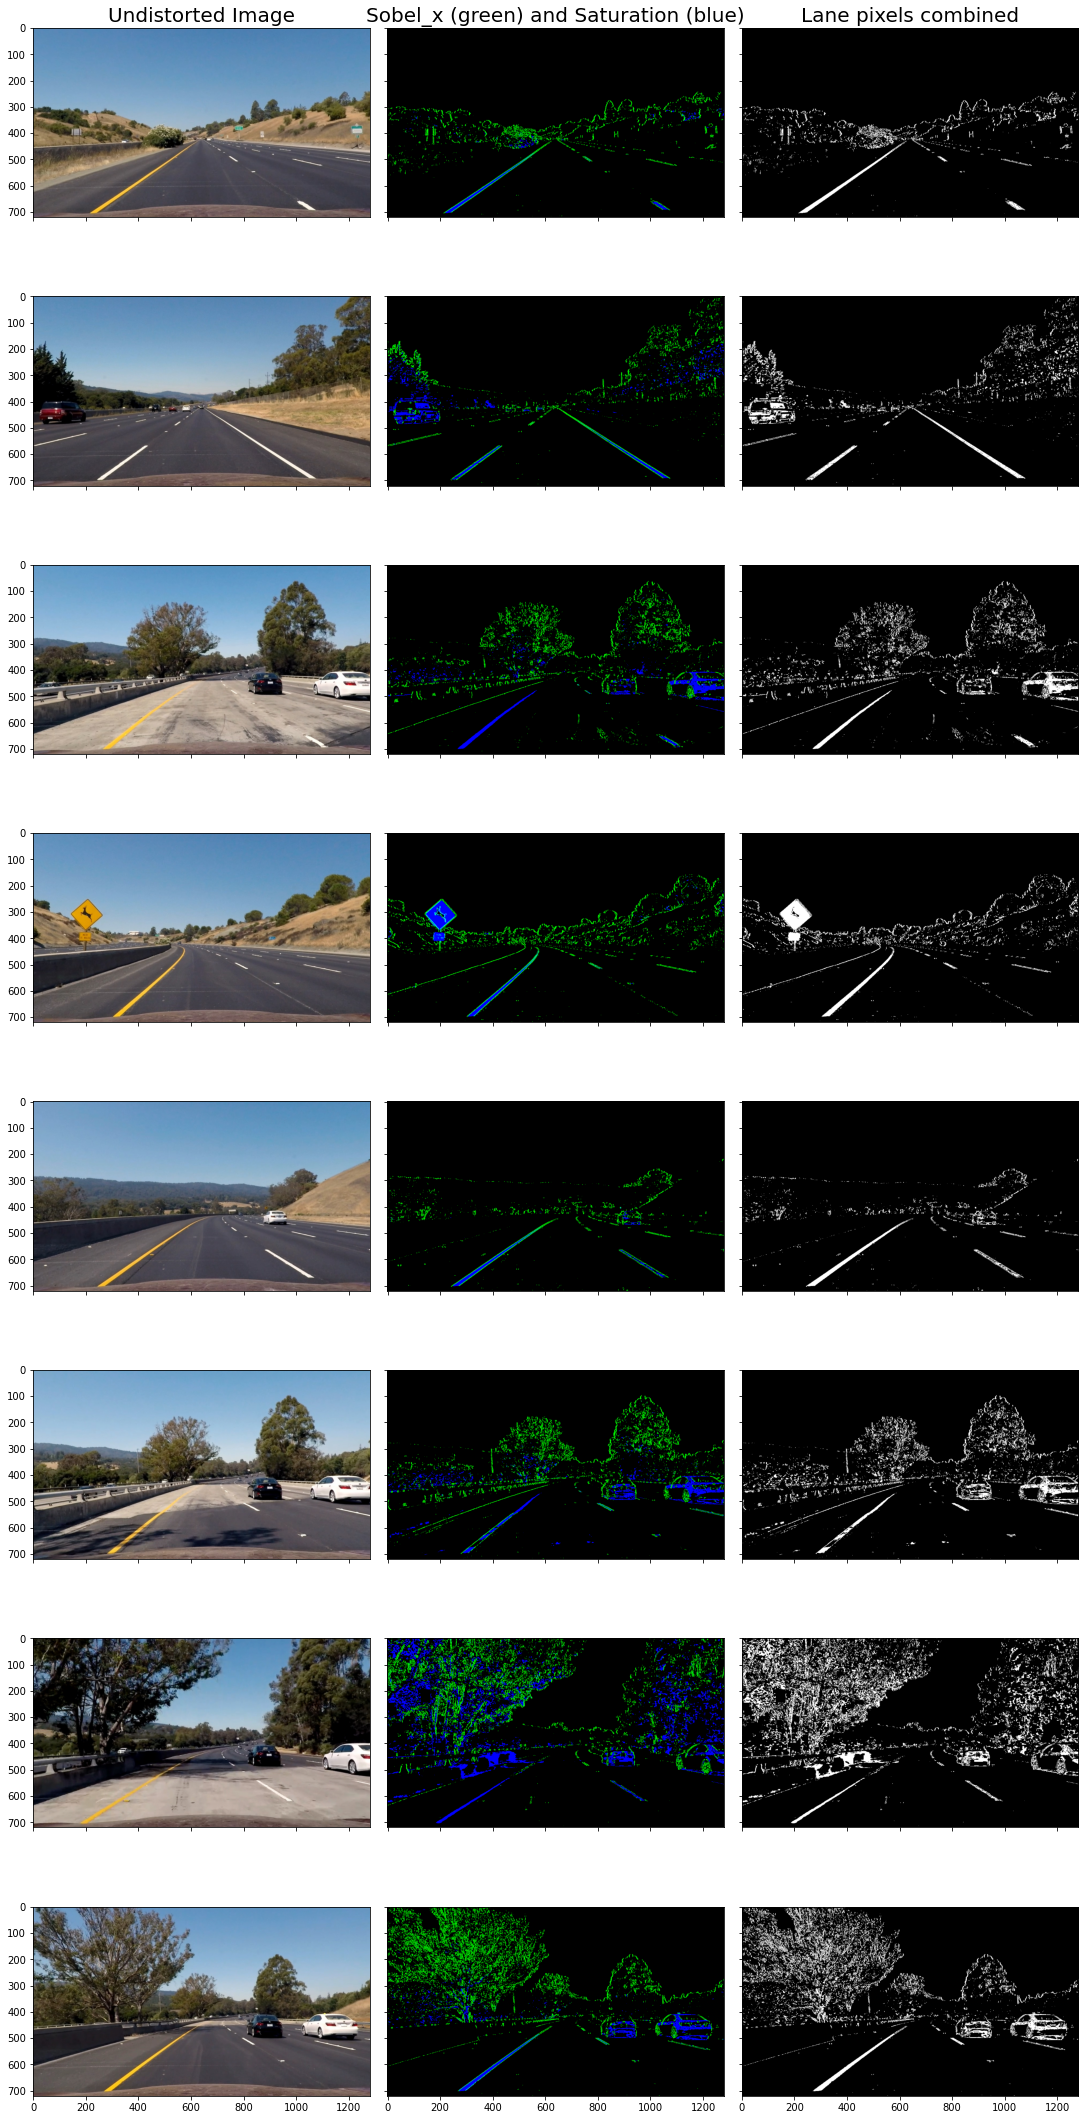

In [4]:
# Apply on test images
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

# Get all file names
path = 'test_images'
file_names = [join(path,f) for f in listdir(path) if (isfile(join(path, f)) and (".jpg" in f))]

# Create canvas to thow original and undistorted images
fig, axes = plt.subplots(nrows=len(file_names), ncols=3,sharex=True,sharey=True,figsize=(15,30))
plt.tight_layout(pad=0.2)
axes[0][0].set_title('Undistorted Image', fontsize=20)
axes[0][1].set_title('Sobel_x (green) and Saturation (blue)', fontsize=20)
axes[0][2].set_title('Lane pixels combined', fontsize=20)
    
for i, file_name in enumerate(file_names):
    
    # Read image
    img = cv2.imread(file_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Undistort
    undistorted = cal_undistort(img, calib_dict['cameraMatrix'], calib_dict['distCoeffs'])
    
    # Lane pixels
    sep, combined = lane_pixels(undistorted,s_thresh=(180, 255), sx_thresh=(30, 120))

    # Show
    axes[i][0].imshow(undistorted)
    axes[i][1].imshow(sep)
    axes[i][2].imshow(combined,cmap='gray')


## Warp image: bird's eye view
Warp the image such that it is represented in a bird's eye view

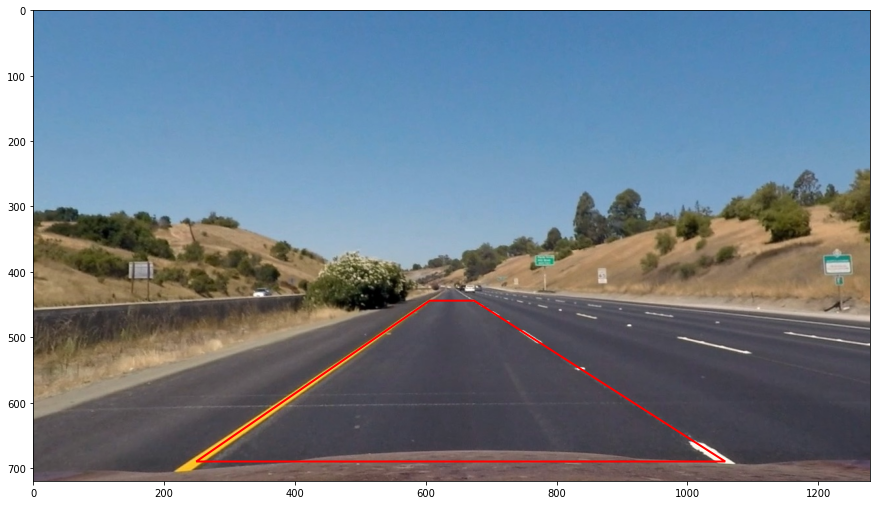

In [5]:
import matplotlib.patches as patches
# Looking at one of the undistorted images, we find this trapeziod 
# 249 690
# 1058 690
# 606 444
# 674 444

#
# Visualize our trapezoid
#

# Read image
img = cv2.imread('output_images/straight_lines1_cal.jpg')
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

trapezoid = np.float32([(249,690),(1058,690),(674,444),(606,444)])

# Show
fig, ax = plt.subplots(nrows=1, ncols=1,sharex=True,sharey=True,figsize=(15,30))
ax.imshow(img)
ax.add_patch(patches.Polygon(xy=trapezoid, fill=False,linewidth=2,color='red'))


In [6]:
def birds_eye(img):

    # Image properties
    height = img.shape[0]
    width = img.shape[1]

    # Our trapeziod in the source image
    src = np.float32([[249,690],[1058,690],[674,444],[606,444]])
        
    # Define destination for the source trapezoid
    dst = np.copy(src)
    # .. only lower half of image
    dst[:,1] = (dst[:,1] - height/2)*2
    # .. bird's eye
    dst[3,0] = dst[0,0]
    dst[2,0] = dst[1,0]

    # Get the transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Do warp
    warped = cv2.warpPerspective(img, M, (width,height))   
    
    return warped

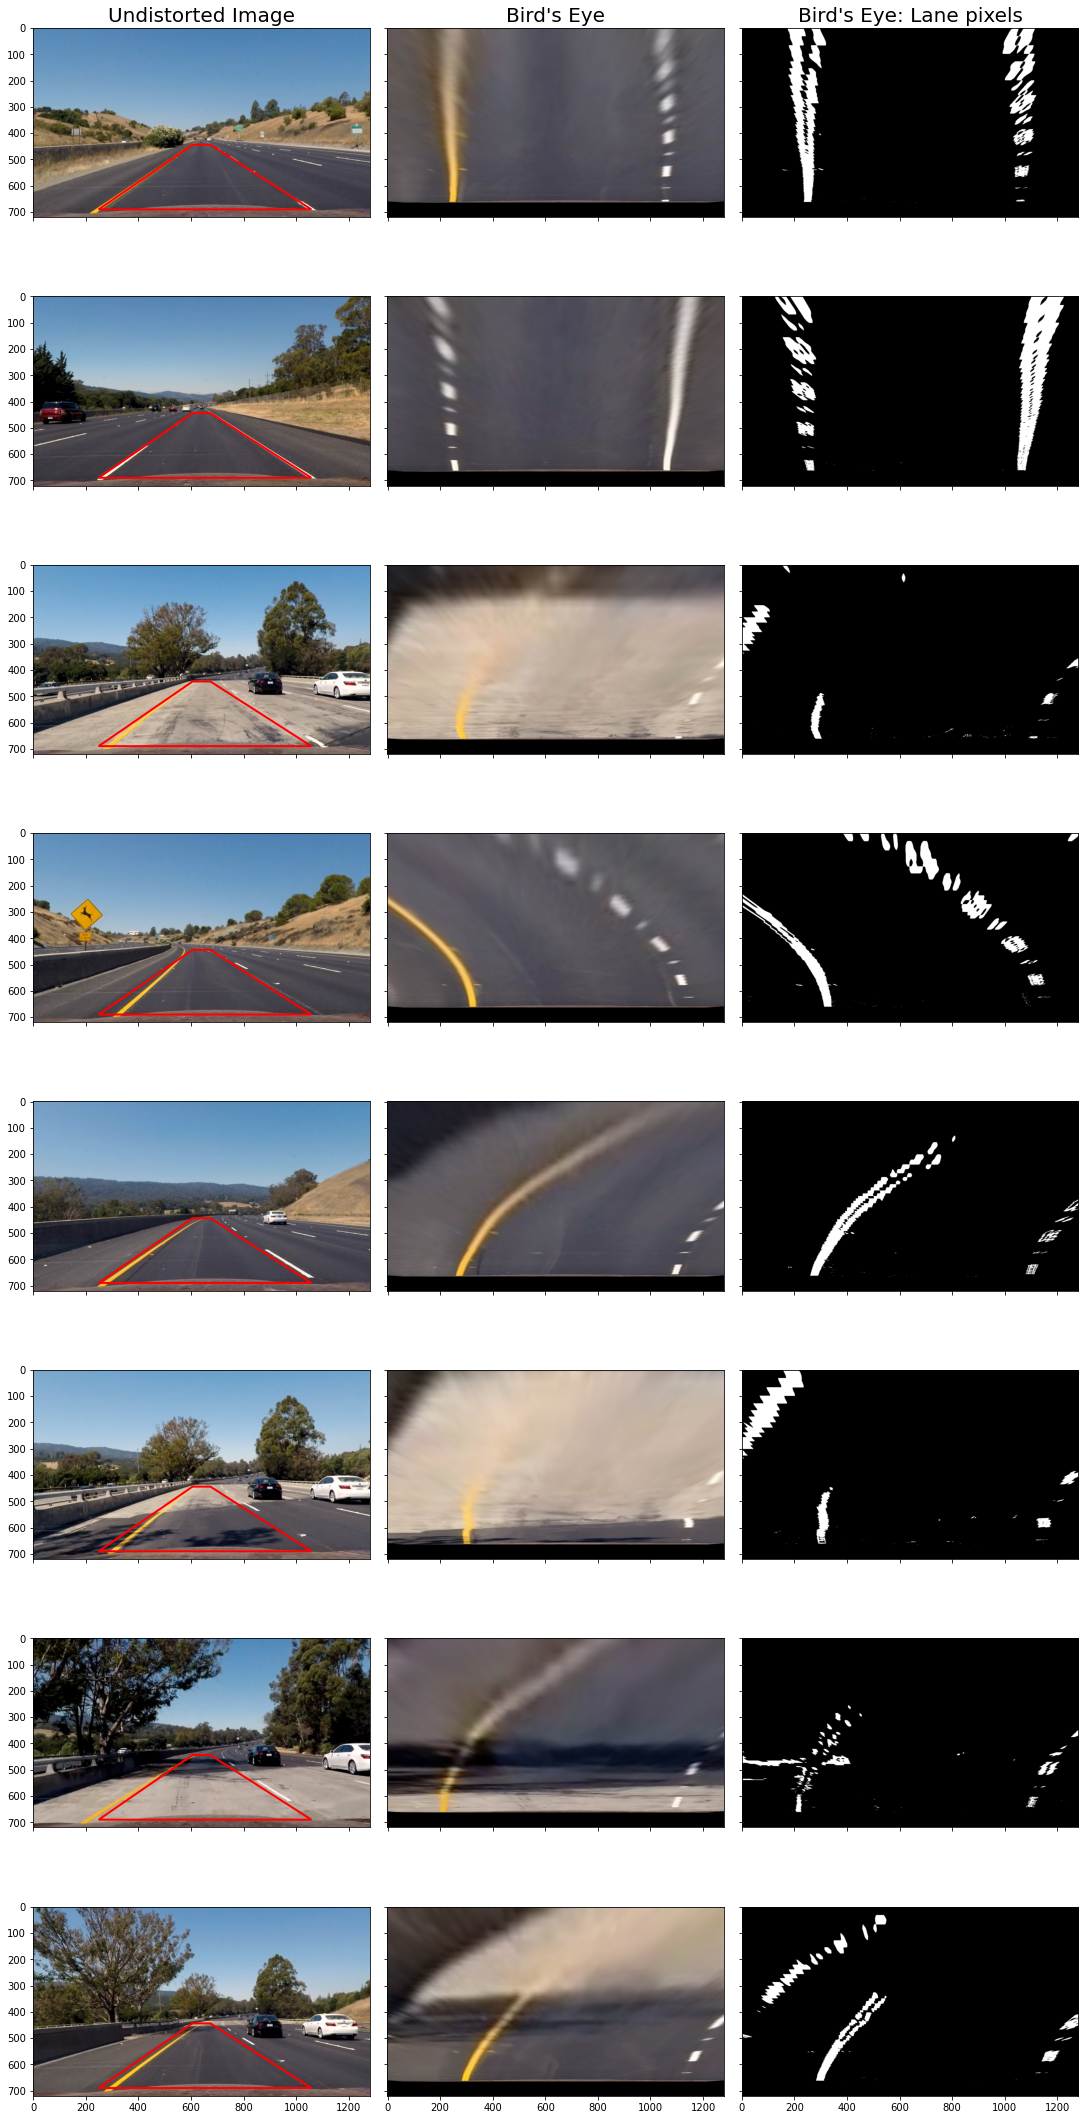

In [7]:
# Apply on test images
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

# Get all file names
path = 'test_images'
file_names = [join(path,f) for f in listdir(path) if (isfile(join(path, f)) and (".jpg" in f))]

# Create canvas to thow original and undistorted images
fig, axes = plt.subplots(nrows=len(file_names), ncols=3,sharex=True,sharey=True,figsize=(15,30))
plt.tight_layout(pad=0.2)
axes[0][0].set_title('Undistorted Image', fontsize=20)
axes[0][1].set_title('Bird\'s Eye', fontsize=20)
axes[0][2].set_title('Bird\'s Eye: Lane pixels', fontsize=20)
    
for i, file_name in enumerate(file_names):
    
    # Read image
    img = cv2.imread(file_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Undistort
    undistorted = cal_undistort(img, calib_dict['cameraMatrix'], calib_dict['distCoeffs'])
    
    # Lane pixels
    sep, combined = lane_pixels(undistorted,s_thresh=(180, 255), sx_thresh=(30, 120))

    # warp
    warp = birds_eye(undistorted)
    warp_lanes = birds_eye(combined)
    
    # Show
    axes[i][0].imshow(undistorted)
    axes[i][0].add_patch(patches.Polygon(xy=trapezoid, fill=False,linewidth=2,color='red'))
    axes[i][1].imshow(warp)
    axes[i][2].imshow(warp_lanes,cmap='gray')

# Fit lanes
We fit a polynomial to selected lane pixels

In [53]:
# Our parameters
# We'll fit 
# x1 = a1 + b*y + c*y^2
# x2 = a1 + a2 + b*y + c*y^2


def reset_params():
    global params
    params['a1']=300 # x position of left lane
    params['a2']=800 # distance of scnd lane to first lane
    params['b'] = 0 
    params['c'] = 0
    # Uncertainties
    params['a1_e']=100 
    params['a2_e']=100 
    params['b_e'] = 1e-14
    params['c_e'] = 3e-4

# Create params dict and set values
params = dict()
reset_params()

In [48]:

def predict(params,y,height):
    '''
    params - dict with a1, a2, b, c to predict
             x1 = a1 + b*y + c*y^2 and
             x2 = a1 + a2 + b*y + c*y^2
    y      - y pixel 
                 ^
               0 |
                 |
              768|------->
    '''
    y = (height-y) 
    #     #
    #     # with b
    #     #
    #     x1 = params['a1'] + params['b'] * y + params['c']*(y**2)
    #     x2 = params['a1'] + params['a2'] + params['b'] * y + params['c']*(y**2)

    #     x1_e = params['a1_e'] + params['b_e']*y + params['c_e']*(y**2)
    #     x2_e = params['a1_e'] + params['a2_e'] + params['b_e']*y + params['c_e']*(y**2)
    
    #
    # without b
    #
    x1 = params['a1']              + params['c']*(y**2)
    x2 = params['a1']+params['a2'] + params['c']*(y**2)

    x1_e = params['a1_e']                + params['c_e']*(y**2)
    x2_e = params['a1_e']+params['a2_e'] + params['c_e']*(y**2)
    
    return x1,x2,x1_e,x2_e


In [49]:
# Test predict on an array
import numpy as np
y = np.linspace(0,100,11)
print(y)
x = predict(params,y,100)
print(x)

[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100.]
(array([300., 300., 300., 300., 300., 300., 300., 300., 300., 300., 300.]), array([1100., 1100., 1100., 1100., 1100., 1100., 1100., 1100., 1100.,
       1100., 1100.]), array([102.  , 101.62, 101.28, 100.98, 100.72, 100.5 , 100.32, 100.18,
       100.08, 100.02, 100.  ]), array([202.  , 201.62, 201.28, 200.98, 200.72, 200.5 , 200.32, 200.18,
       200.08, 200.02, 200.  ]))


In [91]:
def update(params,y,height,x):
    '''
    Let's try a ML way of doing this.
    '''

    # This might be a loop
    for epoch in range(0,50):
        print(epoch)

        # Predict all x
        x1p,x2p,x1p_e,x2p_e = predict(params,y,height)

        # Reject all points outside of 3sigma error bands
        keep_left = np.zeros_like(y,dtype=bool)
        keep_left[ (np.abs(x-x1p)<3.*x1p_e)] = True
        keep_right = np.zeros_like(y,dtype=bool)
        keep_right[ (np.abs(x-x1p)<3.*x1p_e)] = True
        x_left = x[keep_left]
        y_left = y[keep_left]
        xp_left = x1p[keep_left]
        x_right = x[keep_right]
        y_right = y[keep_right]
        xp_right = x2p[keep_right]
            
        # xp_left = a1 + c*(y**2)
        # delta_xleft = (xp_left - x_left) = a1 + c*(y**2) - x
        # dx/da1 = 1
        # dx/dc = y**2
        # delta_x = delta_c * dx/dc
        # --> delta_c = delta_x / dx/dc
        
        # deltas
        d_left = xp_left - x_left
        d_right = xp_right - x_right
        #print('shape of d_left: ',d_left.shape)
        #print('shape of d_right: ',d_right.shape)
        # Average da1 = delta / 1
        da1 = np.mean(np.concatenate((d_left,d_right)))
        # da2
        da2 = np.mean(d_right)
        # dc
        y_left[y_left==0]=1
        y_right[y_right==0]=1
        dc = np.mean(np.concatenate((d_left/(y_left**2),d_right/(y_right**2)))) 

        # update
        #print('Update..params were:',params)
        lr = 1e-5
        params['a1'] = params['a1'] - lr*da1
        params['a2'] = params['a2'] - lr*da2
        params['c'] = params['c'] - lr*dc
        #print('      ..params are:',params)
    return

In [96]:
from scipy.optimize import curve_fit
#from scipy import asarray as ar,exp

is_seeded = False

def two_gaus(x,height1,height2,mean,dist,sigma1,sigma2):
    one = height1*np.exp(-(x-mean)**2/(2*sigma1**2))
    two = height2*np.exp(-(x-(mean+dist))**2/(2*sigma2**2))
    return one + two
                        
def seed(img,x_window=100,n_y_windows=5):
    '''
    Find the beginning of the lane markings without prior 
    '''
    global is_seeded
    global params
    
    if(is_seeded):
        return
    
    # Reset the params
    reset_params()
    
    #
    # Seed the intersect a1 and a2
    #
    
    # Get a1, the x position of the left lane, 
    # as the weighted mean of all lane pixels in lower half 
    #histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    img_height = img.shape[0]
    y_half = img_height//2
    weights = np.linspace(0.,1.,y_half)
    histogram = np.dot(img[y_half:,:].T,weights)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Seed the first params
    params['a1'] = leftx_base
    params['a2'] = rightx_base - leftx_base
    
    # Gaussian fit and use width as uncertainty
    x = np.linspace(0,len(histogram)-1,len(histogram))
    y = histogram
    # height1,height2,mean,dist,sigma1,sigma2
    (h1,h2,params['a1'],params['a2'],params['a1_e'],params['a2_e']),_ = curve_fit(
        two_gaus,x,y,p0=[10,10,params['a1'],params['a2'],params['a1_e'],params['a2_e']])
    # absolute value of width
    params['a1_e'] = abs(params['a1_e'])
    params['a2_e'] = abs(params['a2_e'])
    print(params)
    
    # Value of the Gauss function to show later
    gauss_fit_y = two_gaus(x,h1,h2,params['a1'],params['a2'],params['a1_e'],params['a2_e'])
    
    #
    # Get a value for curvature
    # 
#     nonzero = img[y_half:,:].nonzero()
#     nonzeroy = np.array(nonzero[0])
#     nonzerox = np.array(nonzero[1])
#     update(params,nonzeroy,img_height-y_half,nonzerox)
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    update(params,nonzeroy,img_height,nonzerox)
    
    
    # Collect 
    is_seeded = True
    
    # Show seeding for a1 and a2
    return histogram,gauss_fit_y

    #
    # Sliding window and update
    #
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Loop over all n_y_windows
    y_step = img_height//n_y_windows
    for i_win in range(n_y_windows):
        print('i_win: ',i_win,'/',n_y_windows-1)
        
        # Select pixels to fit
        y_high = img_height - i_win*y_step
        y_low = img_height - (i_win+1)*y_step
        #print('y_high: ',y_high,'y_low: ',y_low, 'img_height: ',img_height)
        
        x1,x2 = predict(params,(y_high+y_low)//2,img_height)
        
        x1_low = x1 - x_window
        x1_high = x1 + x_window
        x2_low = x2 - x_window
        x2_high = x2 + x_window
        
        good_left_inds = ((nonzeroy>y_low) & (nonzeroy<=y_high) &
                          (nonzerox>x1_low) & (nonzerox<=x1_high)).nonzero()[0]
        good_right_inds = ((nonzeroy>y_low) & (nonzeroy<=y_high) &
                           (nonzerox>x2_low) & (nonzerox<=x2_high)).nonzero()[0]
        
        # NOTE: in a real kalman, we'd only need to 
        #
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if(len(good_left_inds) > minpix):
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
            #print('leftx_current: ',leftx_current)
        if(len(good_right_inds) > minpix):
            rightx_current = int(np.mean(nonzerox[good_right_inds]))
            #print('rightx_current: ',rightx_current)
        
        left_lane_inds_array = np.concatenate(left_lane_inds)
        right_lane_inds_array = np.concatenate(right_lane_inds)
        
        
        
    # 

    # Collect 
    is_seeded = True
    
    return histogram

{'a1': 250.12184459851613, 'a2': 811.958307300271, 'b': 0, 'c': 0, 'a1_e': 15.034387063280626, 'a2_e': 18.66083567798469, 'b_e': 1e-14, 'c_e': 0.0003}
0
Update..params were: {'a1': 250.12184459851613, 'a2': 811.958307300271, 'b': 0, 'c': 0, 'a1_e': 15.034387063280626, 'a2_e': 18.66083567798469, 'b_e': 1e-14, 'c_e': 0.0003}
      ..params are: {'a1': 250.1176815858263, 'a2': 811.9500844960447, 'b': 0, 'c': -2.7154767965469098e-05, 'a1_e': 15.034387063280626, 'a2_e': 18.66083567798469, 'b_e': 1e-14, 'c_e': 0.0003}
1
Update..params were: {'a1': 250.1176815858263, 'a2': 811.9500844960447, 'b': 0, 'c': -2.7154767965469098e-05, 'a1_e': 15.034387063280626, 'a2_e': 18.66083567798469, 'b_e': 1e-14, 'c_e': 0.0003}
      ..params are: {'a1': 250.11357994365093, 'a2': 811.9419231034469, 'b': 0, 'c': -5.341792924553709e-05, 'a1_e': 15.034387063280626, 'a2_e': 18.66083567798469, 'b_e': 1e-14, 'c_e': 0.0003}
2
Update..params were: {'a1': 250.11357994365093, 'a2': 811.9419231034469, 'b': 0, 'c': -5.34

Update..params were: {'a1': 250.03856938078218, 'a2': 811.7816668144444, 'b': 0, 'c': -0.0004432188024617384, 'a1_e': 15.034387063280626, 'a2_e': 18.66083567798469, 'b_e': 1e-14, 'c_e': 0.0003}
      ..params are: {'a1': 250.0354077172152, 'a2': 811.7744462425434, 'b': 0, 'c': -0.00045581290982920535, 'a1_e': 15.034387063280626, 'a2_e': 18.66083567798469, 'b_e': 1e-14, 'c_e': 0.0003}
24
Update..params were: {'a1': 250.0354077172152, 'a2': 811.7744462425434, 'b': 0, 'c': -0.00045581290982920535, 'a1_e': 15.034387063280626, 'a2_e': 18.66083567798469, 'b_e': 1e-14, 'c_e': 0.0003}
      ..params are: {'a1': 250.0322744943219, 'a2': 811.7672541474188, 'b': 0, 'c': -0.000467993196063115, 'a1_e': 15.034387063280626, 'a2_e': 18.66083567798469, 'b_e': 1e-14, 'c_e': 0.0003}
25
Update..params were: {'a1': 250.0322744943219, 'a2': 811.7672541474188, 'b': 0, 'c': -0.000467993196063115, 'a1_e': 15.034387063280626, 'a2_e': 18.66083567798469, 'b_e': 1e-14, 'c_e': 0.0003}
      ..params are: {'a1': 250

Update..params were: {'a1': 249.97163540657152, 'a2': 811.6213868670345, 'b': 0, 'c': -0.0006487838272470648, 'a1_e': 15.034387063280626, 'a2_e': 18.66083567798469, 'b_e': 1e-14, 'c_e': 0.0003}
      ..params are: {'a1': 249.96893834804152, 'a2': 811.6146317015701, 'b': 0, 'c': -0.0006546256879325657, 'a1_e': 15.034387063280626, 'a2_e': 18.66083567798469, 'b_e': 1e-14, 'c_e': 0.0003}
47
Update..params were: {'a1': 249.96893834804152, 'a2': 811.6146317015701, 'b': 0, 'c': -0.0006546256879325657, 'a1_e': 15.034387063280626, 'a2_e': 18.66083567798469, 'b_e': 1e-14, 'c_e': 0.0003}
      ..params are: {'a1': 249.96625454523877, 'a2': 811.6078898256089, 'b': 0, 'c': -0.0006602756951444065, 'a1_e': 15.034387063280626, 'a2_e': 18.66083567798469, 'b_e': 1e-14, 'c_e': 0.0003}
48
Update..params were: {'a1': 249.96625454523877, 'a2': 811.6078898256089, 'b': 0, 'c': -0.0006602756951444065, 'a1_e': 15.034387063280626, 'a2_e': 18.66083567798469, 'b_e': 1e-14, 'c_e': 0.0003}
      ..params are: {'a1':

Update..params were: {'a1': 252.99611547830307, 'a2': 819.5405100748937, 'b': 0, 'c': -0.0008102471927468168, 'a1_e': 16.168292698408273, 'a2_e': 17.932456370314796, 'b_e': 1e-14, 'c_e': 0.0003}
      ..params are: {'a1': 252.9937953704402, 'a2': 819.5340922644805, 'b': 0, 'c': -0.0008157398732856688, 'a1_e': 16.168292698408273, 'a2_e': 17.932456370314796, 'b_e': 1e-14, 'c_e': 0.0003}
45
Update..params were: {'a1': 252.9937953704402, 'a2': 819.5340922644805, 'b': 0, 'c': -0.0008157398732856688, 'a1_e': 16.168292698408273, 'a2_e': 17.932456370314796, 'b_e': 1e-14, 'c_e': 0.0003}
      ..params are: {'a1': 252.99148951317974, 'a2': 819.5276887367587, 'b': 0, 'c': -0.0008209836833275342, 'a1_e': 16.168292698408273, 'a2_e': 17.932456370314796, 'b_e': 1e-14, 'c_e': 0.0003}
46
Update..params were: {'a1': 252.99148951317974, 'a2': 819.5276887367587, 'b': 0, 'c': -0.0008209836833275342, 'a1_e': 16.168292698408273, 'a2_e': 17.932456370314796, 'b_e': 1e-14, 'c_e': 0.0003}
      ..params are: {'a

{'a1': 305.9632316660456, 'a2': 793.6991123732548, 'b': 0, 'c': 0, 'a1_e': 25.19100373960396, 'a2_e': 42.40232153808521, 'b_e': 1e-14, 'c_e': 0.0003}
0
Update..params were: {'a1': 305.9632316660456, 'a2': 793.6991123732548, 'b': 0, 'c': 0, 'a1_e': 25.19100373960396, 'a2_e': 42.40232153808521, 'b_e': 1e-14, 'c_e': 0.0003}
      ..params are: {'a1': 305.9601547785209, 'a2': 793.6920669901683, 'b': 0, 'c': -2.1127475539125174e-05, 'a1_e': 25.19100373960396, 'a2_e': 42.40232153808521, 'b_e': 1e-14, 'c_e': 0.0003}
1
Update..params were: {'a1': 305.9601547785209, 'a2': 793.6920669901683, 'b': 0, 'c': -2.1127475539125174e-05, 'a1_e': 25.19100373960396, 'a2_e': 42.40232153808521, 'b_e': 1e-14, 'c_e': 0.0003}
      ..params are: {'a1': 305.9570471025025, 'a2': 793.684990853815, 'b': 0, 'c': -4.140402802881373e-05, 'a1_e': 25.19100373960396, 'a2_e': 42.40232153808521, 'b_e': 1e-14, 'c_e': 0.0003}
2
Update..params were: {'a1': 305.9570471025025, 'a2': 793.684990853815, 'b': 0, 'c': -4.14040280288

      ..params are: {'a1': 305.8127358077735, 'a2': 793.3819717558777, 'b': 0, 'c': -0.0004269961069312929, 'a1_e': 25.19100373960396, 'a2_e': 42.40232153808521, 'b_e': 1e-14, 'c_e': 0.0003}
42
Update..params were: {'a1': 305.8127358077735, 'a2': 793.3819717558777, 'b': 0, 'c': -0.0004269961069312929, 'a1_e': 25.19100373960396, 'a2_e': 42.40232153808521, 'b_e': 1e-14, 'c_e': 0.0003}
      ..params are: {'a1': 305.8090453659034, 'a2': 793.3743144041488, 'b': 0, 'c': -0.00043002289348703247, 'a1_e': 25.19100373960396, 'a2_e': 42.40232153808521, 'b_e': 1e-14, 'c_e': 0.0003}
43
Update..params were: {'a1': 305.8090453659034, 'a2': 793.3743144041488, 'b': 0, 'c': -0.00043002289348703247, 'a1_e': 25.19100373960396, 'a2_e': 42.40232153808521, 'b_e': 1e-14, 'c_e': 0.0003}
      ..params are: {'a1': 305.8053564709675, 'a2': 793.3666586376409, 'b': 0, 'c': -0.00043289152774648033, 'a1_e': 25.19100373960396, 'a2_e': 42.40232153808521, 'b_e': 1e-14, 'c_e': 0.0003}
44
Update..params were: {'a1': 305

Update..params were: {'a1': 322.7840528084461, 'a2': 806.5416398641225, 'b': 0, 'c': -7.078302711388646e-07, 'a1_e': 46.992068000783874, 'a2_e': 49.136600480784466, 'b_e': 1e-14, 'c_e': 0.0003}
      ..params are: {'a1': 322.7812514720335, 'a2': 806.5348058195106, 'b': 0, 'c': -7.228826700442155e-07, 'a1_e': 46.992068000783874, 'a2_e': 49.136600480784466, 'b_e': 1e-14, 'c_e': 0.0003}
48
Update..params were: {'a1': 322.7812514720335, 'a2': 806.5348058195106, 'b': 0, 'c': -7.228826700442155e-07, 'a1_e': 46.992068000783874, 'a2_e': 49.136600480784466, 'b_e': 1e-14, 'c_e': 0.0003}
      ..params are: {'a1': 322.77845021339766, 'a2': 806.5279718868456, 'b': 0, 'c': -7.3793440038074e-07, 'a1_e': 46.992068000783874, 'a2_e': 49.136600480784466, 'b_e': 1e-14, 'c_e': 0.0003}
49
Update..params were: {'a1': 322.77845021339766, 'a2': 806.5279718868456, 'b': 0, 'c': -7.3793440038074e-07, 'a1_e': 46.992068000783874, 'a2_e': 49.136600480784466, 'b_e': 1e-14, 'c_e': 0.0003}
      ..params are: {'a1': 3

      ..params are: {'a1': 305.96560982248053, 'a2': 839.4319516741474, 'b': 0, 'c': -0.0007252561949585735, 'a1_e': 12.742818525532739, 'a2_e': 17.255919249444297, 'b_e': 1e-14, 'c_e': 0.0003}
41
Update..params were: {'a1': 305.96560982248053, 'a2': 839.4319516741474, 'b': 0, 'c': -0.0007252561949585735, 'a1_e': 12.742818525532739, 'a2_e': 17.255919249444297, 'b_e': 1e-14, 'c_e': 0.0003}
      ..params are: {'a1': 305.961869963012, 'a2': 839.4240146549205, 'b': 0, 'c': -0.0007341062033969628, 'a1_e': 12.742818525532739, 'a2_e': 17.255919249444297, 'b_e': 1e-14, 'c_e': 0.0003}
42
Update..params were: {'a1': 305.961869963012, 'a2': 839.4240146549205, 'b': 0, 'c': -0.0007341062033969628, 'a1_e': 12.742818525532739, 'a2_e': 17.255919249444297, 'b_e': 1e-14, 'c_e': 0.0003}
      ..params are: {'a1': 305.95815337056433, 'a2': 839.4161009423995, 'b': 0, 'c': -0.0007427106467654315, 'a1_e': 12.742818525532739, 'a2_e': 17.255919249444297, 'b_e': 1e-14, 'c_e': 0.0003}
43
Update..params were: {'

{'a1': 331.4604925262009, 'a2': 839.4629995686855, 'b': 0, 'c': 0, 'a1_e': 37.12181920405069, 'a2_e': 20.264018909619846, 'b_e': 1e-14, 'c_e': 0.0003}
0
Update..params were: {'a1': 331.4604925262009, 'a2': 839.4629995686855, 'b': 0, 'c': 0, 'a1_e': 37.12181920405069, 'a2_e': 20.264018909619846, 'b_e': 1e-14, 'c_e': 0.0003}
      ..params are: {'a1': 331.4563284779956, 'a2': 839.4546382054824, 'b': 0, 'c': -1.1576851554895936e-07, 'a1_e': 37.12181920405069, 'a2_e': 20.264018909619846, 'b_e': 1e-14, 'c_e': 0.0003}
1
Update..params were: {'a1': 331.4563284779956, 'a2': 839.4546382054824, 'b': 0, 'c': -1.1576851554895936e-07, 'a1_e': 37.12181920405069, 'a2_e': 20.264018909619846, 'b_e': 1e-14, 'c_e': 0.0003}
      ..params are: {'a1': 331.45216470587803, 'a2': 839.4462771601737, 'b': 0, 'c': -2.3151643237140036e-07, 'a1_e': 37.12181920405069, 'a2_e': 20.264018909619846, 'b_e': 1e-14, 'c_e': 0.0003}
2
Update..params were: {'a1': 331.45216470587803, 'a2': 839.4462771601737, 'b': 0, 'c': -2.3

      ..params are: {'a1': 331.2982569580784, 'a2': 839.1370996825135, 'b': 0, 'c': -4.498617352509159e-06, 'a1_e': 37.12181920405069, 'a2_e': 20.264018909619846, 'b_e': 1e-14, 'c_e': 0.0003}
39
Update..params were: {'a1': 331.2982569580784, 'a2': 839.1370996825135, 'b': 0, 'c': -4.498617352509159e-06, 'a1_e': 37.12181920405069, 'a2_e': 20.264018909619846, 'b_e': 1e-14, 'c_e': 0.0003}
      ..params are: {'a1': 331.29410162684985, 'a2': 839.1287486657865, 'b': 0, 'c': -4.61353105084227e-06, 'a1_e': 37.12181920405069, 'a2_e': 20.264018909619846, 'b_e': 1e-14, 'c_e': 0.0003}
40
Update..params were: {'a1': 331.29410162684985, 'a2': 839.1287486657865, 'b': 0, 'c': -4.61353105084227e-06, 'a1_e': 37.12181920405069, 'a2_e': 20.264018909619846, 'b_e': 1e-14, 'c_e': 0.0003}
      ..params are: {'a1': 331.28994638479037, 'a2': 839.1203977799837, 'b': 0, 'c': -4.72841947830806e-06, 'a1_e': 37.12181920405069, 'a2_e': 20.264018909619846, 'b_e': 1e-14, 'c_e': 0.0003}
41
Update..params were: {'a1': 3

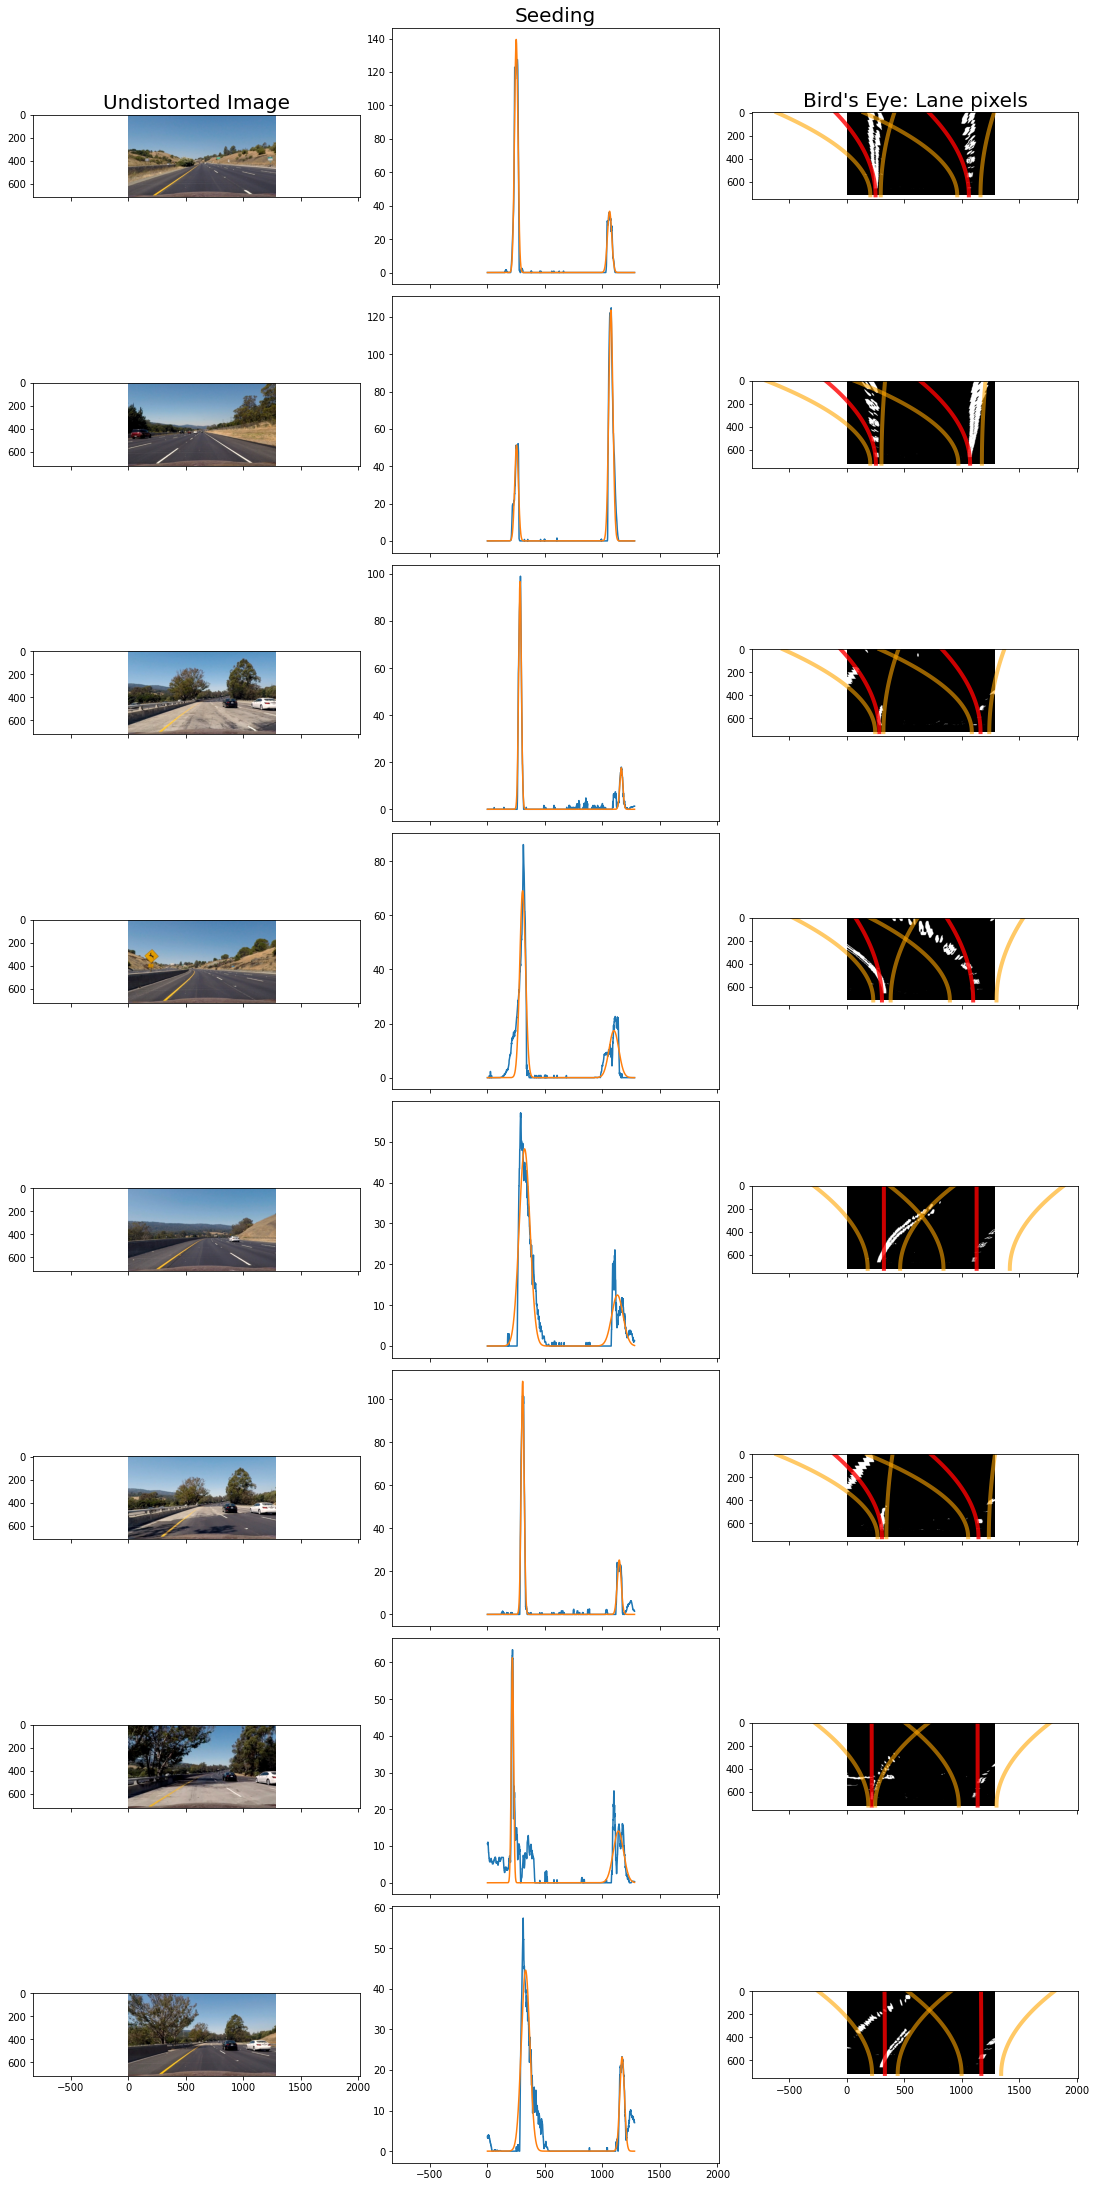

In [97]:
# Apply on test images
import cv2
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

# Get all file names
path = 'test_images'
file_names = [join(path,f) for f in listdir(path) if (isfile(join(path, f)) and (".jpg" in f))]

# Create canvas to thow original and undistorted images
#fig, axes = plt.subplots(nrows=len(file_names), ncols=3,sharex=True,sharey=True,figsize=(15,30))
fig, axes = plt.subplots(nrows=len(file_names), ncols=3,sharex=True,sharey=False,figsize=(15,30))
plt.tight_layout(pad=0.2)
axes[0][0].set_title('Undistorted Image', fontsize=20)
axes[0][1].set_title('Seeding', fontsize=20)
axes[0][2].set_title('Bird\'s Eye: Lane pixels', fontsize=20)
    
for i, file_name in enumerate(file_names):
    
    # Read image
    img = cv2.imread(file_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Undistort
    undistorted = cal_undistort(img, calib_dict['cameraMatrix'], calib_dict['distCoeffs'])
    
    # Lane pixels
    sep, combined = lane_pixels(undistorted,s_thresh=(180, 255), sx_thresh=(30, 120))

    # warp
    warp = birds_eye(undistorted)
    warp_lanes = birds_eye(combined)
    
    # predict the lanes
    is_seeded = False
    histogram,gauss_y = seed(warp_lanes)
    height = warp_lanes.shape[0]
    y = np.linspace(0,height)
    x1,x2,x1_e,x2_e = predict(params,y,height)
    
    # Show
    #  ..colored picture
    axes[i][0].imshow(undistorted)
    #  ..seeding
    axes[i][1].plot(histogram)
    axes[i][1].plot(gauss_y)
    
    #  ..lane pixels 
    axes[i][2].imshow(warp_lanes,cmap='gray')
    #  ..left prediction
    axes[i][2].plot(x1, y,'r',linewidth=4,alpha=0.8)
    axes[i][2].plot(x1-3*x1_e, y,'orange',linewidth=4,alpha=0.6)
    axes[i][2].plot(x1+3*x1_e, y,'orange',linewidth=4,alpha=0.6)

    axes[i][2].plot(x2, y,'r',linewidth=4,alpha=0.8)
    axes[i][2].plot(x2-3*x2_e, y,'orange',linewidth=4,alpha=0.6)
    axes[i][2].plot(x2+3*x2_e, y,'orange',linewidth=4,alpha=0.6)
    
    